# Compare albedo feedback

Author: Ziqi Yin

Last modified: 2024 Feb 18

Table of contents:
* [Maps of GrIS bulk albedo feedback and difference](#first-bullet)
* [Maps of GrIS albedo feedback and difference](#second-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
from math import radians, sin, cos, sqrt, atan2

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

## 1. Bulk albedo feedback <a class="anchor" id="first-bullet"></a>

### Read data

In [2]:
## BG iteration 7
BG7_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TREFHT_JJA_yearly.nc')['TREFHT'] #TREFHT (2m air temperature)[K]
BG7_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSDS_JJA_yearly.nc')['FSDS']
BG7_FSA_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSA_JJA_yearly.nc')['FSA']

# Since ice sheet mask and topography are updated every twenty years, annnual mean value is the same to JJA mean
f09_lon = BG7_TREFHT_JJA_yearly.lon
f09_lat = BG7_TREFHT_JJA_yearly.lat

In [3]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:140,:,:]
f09_1pctCO2_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_1pctCO2_JJA.nc')['FSDS'][0:140,:,:]
f09_1pctCO2_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSR_1pctCO2_JJA.nc')['FSR'][0:140,:,:]

# 4xext
f09_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
f09_4xext_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_4xext_JJA.nc')['FSDS']
f09_4xext_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSR_4xext_JJA.nc')['FSR']

In [4]:
## f09nohacks
# piControl
f09_nohacks_piControl_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_piControl_JJA_yearly.nc')['TREFHT']
f09_nohacks_piControl_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_piControl_JJA_yearly.nc')['FSDS'] # atmospheric incident solar radiation [W/m2] 
f09_nohacks_piControl_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_piControl_JJA_yearly.nc')['FSR'] # reflected solar radiation [W/m2] 

# 1pctCO2
f09_nohacks_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']
f09_nohacks_1pctCO2_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_1pctCO2_JJA_yearly.nc')['FSDS']
f09_nohacks_1pctCO2_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_1pctCO2_JJA_yearly.nc')['FSR']

# 4xext
f09_nohacks_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
f09_nohacks_4xext_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_4xext_JJA_yearly.nc')['FSDS']
f09_nohacks_4xext_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_4xext_JJA_yearly.nc')['FSR']

In [5]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_piControl_p4_JJA_yearly.nc')['TREFHT']
ARCTIC_piControl_p4_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_piControl_p4_JJA.nc')['FSDS']
ARCTIC_piControl_p4_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_piControl_p4_JJA.nc')['FSR']

# 1pctCO2
ARCTIC_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']
ARCTIC_1pctCO2_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_1pctCO2_JJA.nc')['FSDS']
ARCTIC_1pctCO2_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_1pctCO2_JJA.nc')['FSR']

# 4xext
ARCTIC_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
ARCTIC_4xext_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_4xext_JJA.nc')['FSDS']
ARCTIC_4xext_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_4xext_JJA.nc')['FSR']

In [6]:
## Calculate net SW radiation
# BG7_FSA_JJA_yearly)
f09_1pctCO2_FSA_JJA_yearly = f09_1pctCO2_FSDS_JJA_yearly - f09_1pctCO2_FSR_JJA_yearly
f09_4xext_FSA_JJA_yearly = f09_4xext_FSDS_JJA_yearly - f09_4xext_FSR_JJA_yearly

f09_nohacks_piControl_FSA_JJA_yearly = f09_nohacks_piControl_FSDS_JJA_yearly - f09_nohacks_piControl_FSR_JJA_yearly
f09_nohacks_1pctCO2_FSA_JJA_yearly = f09_nohacks_1pctCO2_FSDS_JJA_yearly - f09_nohacks_1pctCO2_FSR_JJA_yearly
f09_nohacks_4xext_FSA_JJA_yearly = f09_nohacks_4xext_FSDS_JJA_yearly - f09_nohacks_4xext_FSR_JJA_yearly

ARCTIC_piControl_p4_FSA_JJA_yearly = ARCTIC_piControl_p4_FSDS_JJA_yearly - ARCTIC_piControl_p4_FSR_JJA_yearly
ARCTIC_1pctCO2_FSA_JJA_yearly = ARCTIC_1pctCO2_FSDS_JJA_yearly - ARCTIC_1pctCO2_FSR_JJA_yearly
ARCTIC_4xext_FSA_JJA_yearly = ARCTIC_4xext_FSDS_JJA_yearly - ARCTIC_4xext_FSR_JJA_yearly

In [7]:
## Calculate albedo
BG7_albedo_JJA_yearly = (BG7_FSDS_JJA_yearly - BG7_FSA_JJA_yearly) / BG7_FSDS_JJA_yearly
f09_1pctCO2_albedo_JJA_yearly = f09_1pctCO2_FSR_JJA_yearly / f09_1pctCO2_FSDS_JJA_yearly
f09_4xext_albedo_JJA_yearly = f09_4xext_FSR_JJA_yearly / f09_4xext_FSDS_JJA_yearly

f09_nohacks_piControl_albedo_JJA_yearly = f09_nohacks_piControl_FSR_JJA_yearly / f09_nohacks_piControl_FSDS_JJA_yearly
f09_nohacks_1pctCO2_albedo_JJA_yearly = f09_nohacks_1pctCO2_FSR_JJA_yearly / f09_nohacks_1pctCO2_FSDS_JJA_yearly
f09_nohacks_4xext_albedo_JJA_yearly = f09_nohacks_4xext_FSR_JJA_yearly / f09_nohacks_4xext_FSDS_JJA_yearly

ARCTIC_piControl_p4_albedo_JJA_yearly = ARCTIC_piControl_p4_FSR_JJA_yearly / ARCTIC_piControl_p4_FSDS_JJA_yearly
ARCTIC_1pctCO2_albedo_JJA_yearly = ARCTIC_1pctCO2_FSR_JJA_yearly / ARCTIC_1pctCO2_FSDS_JJA_yearly
ARCTIC_4xext_albedo_JJA_yearly = ARCTIC_4xext_FSR_JJA_yearly / ARCTIC_4xext_FSDS_JJA_yearly

In [8]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_1pctCO2_TREFHT_JJA_yearly, f09_4xext_TREFHT_JJA_yearly], dim='time')
f09_1pctCO2_4xext_FSA_JJA_yearly = xr.concat([f09_1pctCO2_FSA_JJA_yearly, f09_4xext_FSA_JJA_yearly], dim='time')
f09_1pctCO2_4xext_albedo_JJA_yearly = xr.concat([f09_1pctCO2_albedo_JJA_yearly, f09_4xext_albedo_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_TREFHT_JJA_yearly, f09_nohacks_4xext_TREFHT_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_FSA_JJA_yearly, f09_nohacks_4xext_FSA_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_albedo_JJA_yearly, f09_nohacks_4xext_albedo_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([ARCTIC_1pctCO2_TREFHT_JJA_yearly, ARCTIC_4xext_TREFHT_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_FSA_JJA_yearly  = xr.concat([ARCTIC_1pctCO2_FSA_JJA_yearly, ARCTIC_4xext_FSA_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_albedo_JJA_yearly  = xr.concat([ARCTIC_1pctCO2_albedo_JJA_yearly, ARCTIC_4xext_albedo_JJA_yearly], dim='time')

In [9]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

In [10]:
## Select
# end of PI (year -19-0)
f09_TREFHT_JJA_PI = BG7_TREFHT_JJA_yearly[129:149,:,:].mean(dim='time')
f09_FSA_JJA_PI = BG7_FSA_JJA_yearly[129:149,:,:].mean(dim='time')
f09_albedo_JJA_PI = BG7_albedo_JJA_yearly[129:149,:,:].mean(dim='time')
f09_GrIS_mask_PI = np.mean(BG7_GrIS_mask[129:149,:,:], axis=0)

f09_nohacks_TREFHT_JJA_PI = f09_nohacks_piControl_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_FSA_JJA_PI = f09_nohacks_piControl_FSA_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_albedo_JJA_PI = f09_nohacks_piControl_albedo_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_PI = np.mean(f09_nohacks_GrIS_mask_piControl[-20:,:,:], axis=0)

ARCTIC_TREFHT_JJA_PI = ARCTIC_piControl_p4_TREFHT_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_FSA_JJA_PI = ARCTIC_piControl_p4_FSA_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_albedo_JJA_PI = ARCTIC_piControl_p4_albedo_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_GrIS_mask_PI = np.mean(ARCTIC_GrIS_mask_piControl[-20:,:], axis=0)

# CO2 stabilization (year 131-150)
f09_TREFHT_JJA_stab = f09_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:].mean(dim='time')
f09_FSA_JJA_stab = f09_1pctCO2_4xext_FSA_JJA_yearly[130:150,:,:].mean(dim='time')
f09_albedo_JJA_stab = f09_1pctCO2_4xext_albedo_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_TREFHT_JJA_stab = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_FSA_JJA_stab = f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_albedo_JJA_stab = f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_TREFHT_JJA_stab = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_FSA_JJA_stab = ARCTIC_1pctCO2_4xext_FSA_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_albedo_JJA_stab = ARCTIC_1pctCO2_4xext_albedo_JJA_yearly[130:150,:].mean(dim='time')

# end of simulation (year 331-350)
f09_TREFHT_JJA_end = f09_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')
f09_FSA_JJA_end = f09_1pctCO2_4xext_FSA_JJA_yearly[-20:,:,:].mean(dim='time')
f09_albedo_JJA_end = f09_1pctCO2_4xext_albedo_JJA_yearly[-20:,:,:].mean(dim='time')
f09_GrIS_mask_end = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

f09_nohacks_TREFHT_JJA_end = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_FSA_JJA_end = f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_albedo_JJA_end = f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_end = np.mean(f09_nohacks_GrIS_mask[-20:,:,:], axis=0)

ARCTIC_TREFHT_JJA_end = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_FSA_JJA_end = ARCTIC_1pctCO2_4xext_FSA_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_albedo_JJA_end = ARCTIC_1pctCO2_4xext_albedo_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_GrIS_mask_end = np.mean(ARCTIC_GrIS_mask[-20:,:], axis=0)

In [11]:
## Mask out grids with zero ice fraction in ARCTIC before remapping, 
## otherwise in f09 grids that covers zero ice fraction ARCTIC grids, the remapped values will suffer from smaller values due to mixed grid types

f09_TREFHT_JJA_end = f09_TREFHT_JJA_end.where(f09_GrIS_mask_end>0)
f09_FSA_JJA_end = f09_FSA_JJA_end.where(f09_GrIS_mask_end>0)

f09_nohacks_TREFHT_JJA_end = f09_nohacks_TREFHT_JJA_end.where(f09_nohacks_GrIS_mask_end>0)
f09_nohacks_FSA_JJA_end = f09_nohacks_FSA_JJA_end.where(f09_nohacks_GrIS_mask_end>0)

ARCTIC_TREFHT_JJA_end = ARCTIC_TREFHT_JJA_end.where(ARCTIC_GrIS_mask_end>0)
ARCTIC_FSA_JJA_end = ARCTIC_FSA_JJA_end.where(ARCTIC_GrIS_mask_end>0)

### Regrid ARCTIC to f09

In [12]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [13]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [14]:
ESMF.Manager(debug=True);

In [15]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

### Calculate

#### From PI to end

In [16]:
# Changes from two 20-year periods: PI to end
f09_dTREFHT_JJA_end_PI = f09_TREFHT_JJA_end - f09_TREFHT_JJA_PI
f09_nohacks_dTREFHT_JJA_end_PI = f09_nohacks_TREFHT_JJA_end - f09_nohacks_TREFHT_JJA_PI
ARCTIC_dTREFHT_JJA_end_PI = ARCTIC_TREFHT_JJA_end - ARCTIC_TREFHT_JJA_PI

f09_dFSA_JJA_end_PI = f09_FSA_JJA_end - f09_FSA_JJA_PI
f09_nohacks_dFSA_JJA_end_PI = f09_nohacks_FSA_JJA_end - f09_nohacks_FSA_JJA_PI
ARCTIC_dFSA_JJA_end_PI = ARCTIC_FSA_JJA_end - ARCTIC_FSA_JJA_PI

f09_dalbedo_JJA_end_PI = f09_albedo_JJA_end - f09_albedo_JJA_PI
f09_nohacks_dalbedo_JJA_end_PI = f09_nohacks_albedo_JJA_end - f09_nohacks_albedo_JJA_PI
ARCTIC_dalbedo_JJA_end_PI = ARCTIC_albedo_JJA_end - ARCTIC_albedo_JJA_PI

In [17]:
# Calculate bulk albedo feedback
f09_baf_JJA_end_PI = f09_dFSA_JJA_end_PI.values / f09_dTREFHT_JJA_end_PI.values
f09_nohacks_baf_JJA_end_PI = f09_nohacks_dFSA_JJA_end_PI.values / f09_nohacks_dTREFHT_JJA_end_PI.values
ARCTIC_baf_JJA_end_PI = ARCTIC_dFSA_JJA_end_PI.values / ARCTIC_dTREFHT_JJA_end_PI.values

# Remap ARCTIC result to f09 grid
ARCTIC2f09_baf_JJA_end_PI = f09_baf_JJA_end_PI * 0
ARCTIC2f09_baf_JJA_end_PI[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_baf_JJA_end_PI, f09_centers, f09_corners)

In [18]:
## Add cyclic points
f09_baf_JJA_end_PI_2, f09_lon2 = add_cyclic_point(f09_baf_JJA_end_PI, coord=f09_lon)
f09_nohacks_baf_JJA_end_PI_2, f09_lon2 = add_cyclic_point(f09_nohacks_baf_JJA_end_PI, coord=f09_lon)
ARCTIC2f09_baf_JJA_end_PI_2, f09_lon2 = add_cyclic_point(ARCTIC2f09_baf_JJA_end_PI, coord=f09_lon)

In [19]:
# Differences between f09 and ARCTIC
f09_ARCTIC_baf_diff_JJA_end_PI_2 = f09_baf_JJA_end_PI_2 - ARCTIC2f09_baf_JJA_end_PI_2
f09_nohacks_ARCTIC_baf_diff_JJA_end_PI_2 = f09_nohacks_baf_JJA_end_PI_2 - ARCTIC2f09_baf_JJA_end_PI_2

### Prepare for plotting SE grids

In [20]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.

    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)

    return var, verts

In [21]:
ARCTIC_baf_JJA_end_PI_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_baf_JJA_end_PI))[0]
ARCTIC_baf_JJA_end_PI_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_baf_JJA_end_PI))[1]

In [22]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

### Plot

In [23]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

#### From PI to end

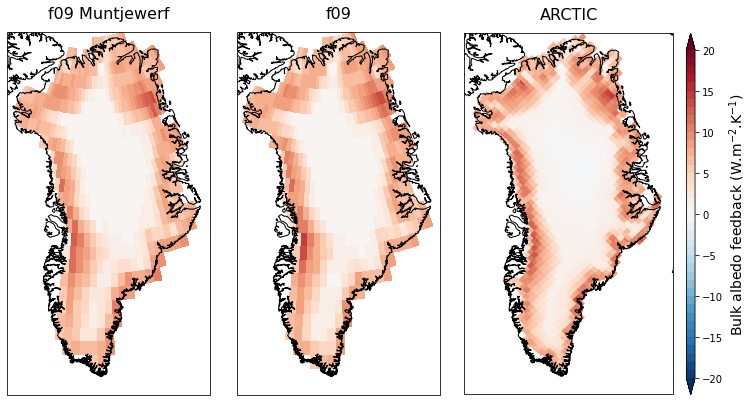

In [24]:
# Bulk albedo feedback
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-20.,20.1,1.)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-20.,20.1,5.)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon2, f09_lat, f09_baf_JJA_end_PI_2, cmap=cmap2, norm=norm2, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('f09 Muntjewerf', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon2, f09_lat, f09_nohacks_baf_JJA_end_PI_2, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('f09', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_baf_JJA_end_PI_verts, cmap=cmap2, transform=crs_ll,
                     **kwd_polycollection)
im3.set_array(ARCTIC_baf_JJA_end_PI_var)
im3.set_clim(vmin=-20, vmax=20)
ax3.add_collection(im3)
plt.title('ARCTIC', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='Bulk albedo feedback (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)


##### Add transect line & basin boundaries

In [25]:
## Add transect line positions
# K transect
kfile = xr.open_dataset(home_dir+'data/ktransect-elev.nc')
klon = kfile.klon
klat = kfile.klat
kdist = kfile.kdist
kzraw = kfile.zraw
kzsims = kfile.zsims

# S transect
sfile = xr.open_dataset(home_dir+'data/stransect-elev.nc')
slon = sfile.slon
slat = sfile.slat
sdist = sfile.sdist
szraw = sfile.zraw
szsims = sfile.zsims

In [26]:
## Add basin boundaries
basin_boundaries5p5 = xr.open_dataset('/glade/campaign/cgd/amp/aherring/racmo/racmo2.3p2/Mouginot2019_basins_5.5km.nc') #same grid to RACMO FGRN055

racmo_data = xr.open_dataset(home_dir+'data/RACMO/BN_RACMO2.3p2_FGRN055_GrIS_precip_timmean_1979_1998.nc') #Calculated from the data in Adam's directory
racmo_rlon = racmo_data['rlon'].values
racmo_rlat = racmo_data['rlat'].values
racmo_ref = xr.open_dataset(home_dir+'data/RACMO/alb.1996.FGRN055_BN_RACMO2.3p2_ERA5_3h_FGRN055.MM.nc')

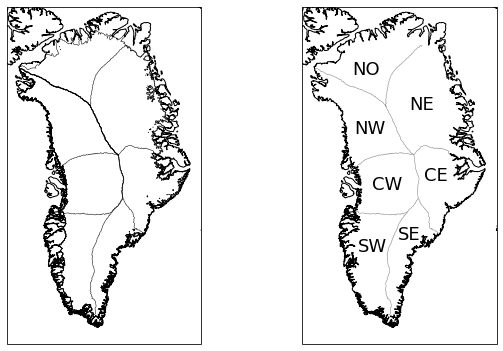

In [27]:
## Select the boundary for each basin so they don't overlap
fig = plt.figure(figsize = (9.7,6.2))
gs=GridSpec(1,2)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------1----------------------------------------------------
ax0 = plt.subplot(gs[0], projection=polar_stereographic)
ax0.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax0.coastlines(resolution='10m')

data_crs = ccrs.RotatedPole(pole_longitude=racmo_ref.rotated_pole.grid_north_pole_longitude,
                            pole_latitude=racmo_ref.rotated_pole.grid_north_pole_latitude)
im0 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[0], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)
im1 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[1], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)
im2 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[2], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)
im3 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[3], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)
im4 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[4], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)
im5 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[5], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)
im6 = ax0.contour(racmo_rlon, racmo_rlat, basin_boundaries5p5.Mouginot_basins, transform=data_crs, levels=[6], colors='black', linewidths=0.5)#, vmin = 0, vmax = 2000)

p0 = im0.collections[0].get_paths()
p1 = im1.collections[0].get_paths()
p2 = im2.collections[0].get_paths()
p3 = im3.collections[0].get_paths()
p4 = im4.collections[0].get_paths()
p5 = im5.collections[0].get_paths()
p6 = im6.collections[0].get_paths()

#---------------------------------------------1----------------------------------------------------
ax1 = plt.subplot(gs[1], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m')

plt.plot(p1[0].vertices[:,0][1377:1605], p1[0].vertices[:,1][1377:1605], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p2[0].vertices[:,0][899:1040], p2[0].vertices[:,1][899:1040], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p3[0].vertices[:,0][408:543], p3[0].vertices[:,1][408:543], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p4[1].vertices[:,0][0:180], p4[1].vertices[:,1][0:180], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p5[0].vertices[:,0][0:20], p5[0].vertices[:,1][0:20], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p5[0].vertices[:,0][932:], p5[0].vertices[:,1][932:], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p6[0].vertices[:,0][0:94], p6[0].vertices[:,1][0:94], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p6[0].vertices[:,0][-4:], p6[0].vertices[:,1][-4:], color='gray', linewidth=0.5, transform=data_crs);

plt.text(-280000, -1200000, 'NO', fontsize=18);
plt.text(200000, -1500000, 'NE', fontsize=18);
plt.text(330000, -2100000, 'CE', fontsize=18);
plt.text(110000, -2600000, 'SE', fontsize=18);
plt.text(-230000, -2700000, 'SW', fontsize=18);
plt.text(-110000, -2180000, 'CW', fontsize=18);
plt.text(-260000, -1700000, 'NW', fontsize=18);

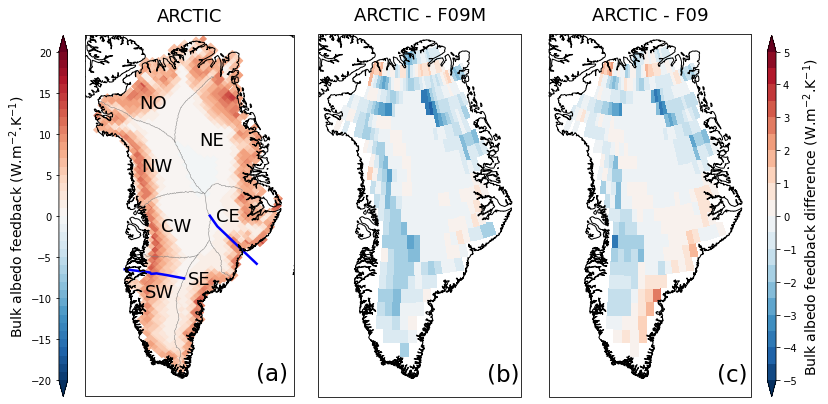

In [28]:
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-20.,20.1,1.)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-20.,20.1,5.)

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-5.,5.1,0.5)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-5.,5.1,1.)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)
im1 = PolyCollection(ARCTIC_baf_JJA_end_PI_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im1.set_array(ARCTIC_baf_JJA_end_PI_var)
im1.set_clim(vmin=-20, vmax=20)
ax1.add_collection(im1)
plt.title('ARCTIC', fontsize = 18)
ax1.text(650000, -3360000, '(a)', fontsize=23)

plt.plot(p1[0].vertices[:,0][1377:1605], p1[0].vertices[:,1][1377:1605], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p2[0].vertices[:,0][899:1040], p2[0].vertices[:,1][899:1040], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p3[0].vertices[:,0][408:543], p3[0].vertices[:,1][408:543], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p4[1].vertices[:,0][0:180], p4[1].vertices[:,1][0:180], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p5[0].vertices[:,0][0:20], p5[0].vertices[:,1][0:20], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p5[0].vertices[:,0][932:], p5[0].vertices[:,1][932:], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p6[0].vertices[:,0][0:94], p6[0].vertices[:,1][0:94], color='gray', linewidth=0.5, transform=data_crs);
plt.plot(p6[0].vertices[:,0][-4:], p6[0].vertices[:,1][-4:], color='gray', linewidth=0.5, transform=data_crs);

plt.text(-280000, -1200000, 'NO', fontsize=18);
plt.text(200000, -1500000, 'NE', fontsize=18);
plt.text(330000, -2100000, 'CE', fontsize=18);
plt.text(110000, -2600000, 'SE', fontsize=18);
plt.text(-230000, -2700000, 'SW', fontsize=18);
plt.text(-105000, -2180000, 'CW', fontsize=18);
plt.text(-260000, -1700000, 'NW', fontsize=18);

plt.plot(klon, klat, color='blue', linewidth=2.5, transform = crs_ll);
plt.plot(slon, slat, color='blue', linewidth=2.5, transform = crs_ll);

# colorbar
cbar_ax1 = fig.add_axes([0.095, 0.125, 0.01, 0.753])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='Bulk albedo feedback (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon2, f09_lat, -f09_ARCTIC_baf_diff_JJA_end_PI_2, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize = 18)
ax2.text(650000, -3360000, '(b)', fontsize=23)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_baf_diff_JJA_end_PI_2, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize = 18)
ax3.text(650000, -3360000, '(c)', fontsize=23)

# colorbar
cbar_ax3 = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb3.set_label(label='Bulk albedo feedback difference (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb3.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_baf_transect_basin_baf_diff_end_PI_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 2. Albedo feedback <a class="anchor" id="second-bullet"></a>

### Read data

In [29]:
## BG iteration 7
BG7_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TREFHT_JJA_yearly.nc')['TREFHT'] #TREFHT (2m air temperature)[K]
BG7_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSDS_JJA_yearly.nc')['FSDS']
BG7_FSA_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSA_JJA_yearly.nc')['FSA']

f09_lon = BG7_TREFHT_JJA_yearly.lon
f09_lat = BG7_TREFHT_JJA_yearly.lat

In [30]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:140,:,:]
f09_1pctCO2_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_1pctCO2_JJA.nc')['FSDS'][0:140,:,:]
f09_1pctCO2_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSR_1pctCO2_JJA.nc')['FSR'][0:140,:,:]

# 4xext
f09_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
f09_4xext_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_4xext_JJA.nc')['FSDS']
f09_4xext_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSR_4xext_JJA.nc')['FSR']

In [31]:
## f09nohacks
# piControl
f09_nohacks_piControl_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_piControl_JJA_yearly.nc')['TREFHT']
f09_nohacks_piControl_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_piControl_JJA_yearly.nc')['FSDS'] # atmospheric incident solar radiation [W/m2] 
f09_nohacks_piControl_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_piControl_JJA_yearly.nc')['FSR'] # reflected solar radiation [W/m2] 

# 1pctCO2
f09_nohacks_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']
f09_nohacks_1pctCO2_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_1pctCO2_JJA_yearly.nc')['FSDS']
f09_nohacks_1pctCO2_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_1pctCO2_JJA_yearly.nc')['FSR']

# 4xext
f09_nohacks_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
f09_nohacks_4xext_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_4xext_JJA_yearly.nc')['FSDS']
f09_nohacks_4xext_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_4xext_JJA_yearly.nc')['FSR']

In [32]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_piControl_p4_JJA_yearly.nc')['TREFHT']
ARCTIC_piControl_p4_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_piControl_p4_JJA.nc')['FSDS']
ARCTIC_piControl_p4_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_piControl_p4_JJA.nc')['FSR']

ARCTIC_lon = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lat.nc')['lat']

# 1pctCO2
ARCTIC_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']
ARCTIC_1pctCO2_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_1pctCO2_JJA.nc')['FSDS']
ARCTIC_1pctCO2_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_1pctCO2_JJA.nc')['FSR']

# 4xext
ARCTIC_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_JJA_yearly.nc')['TREFHT']
ARCTIC_4xext_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_4xext_JJA.nc')['FSDS']
ARCTIC_4xext_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_4xext_JJA.nc')['FSR']

In [33]:
## Calculate net SW radiation
f09_1pctCO2_FSA_JJA_yearly = f09_1pctCO2_FSDS_JJA_yearly - f09_1pctCO2_FSR_JJA_yearly
f09_4xext_FSA_JJA_yearly = f09_4xext_FSDS_JJA_yearly - f09_4xext_FSR_JJA_yearly

f09_nohacks_piControl_FSA_JJA_yearly = f09_nohacks_piControl_FSDS_JJA_yearly - f09_nohacks_piControl_FSR_JJA_yearly
f09_nohacks_1pctCO2_FSA_JJA_yearly = f09_nohacks_1pctCO2_FSDS_JJA_yearly - f09_nohacks_1pctCO2_FSR_JJA_yearly
f09_nohacks_4xext_FSA_JJA_yearly = f09_nohacks_4xext_FSDS_JJA_yearly - f09_nohacks_4xext_FSR_JJA_yearly

ARCTIC_piControl_p4_FSA_JJA_yearly = ARCTIC_piControl_p4_FSDS_JJA_yearly - ARCTIC_piControl_p4_FSR_JJA_yearly
ARCTIC_1pctCO2_FSA_JJA_yearly = ARCTIC_1pctCO2_FSDS_JJA_yearly - ARCTIC_1pctCO2_FSR_JJA_yearly
ARCTIC_4xext_FSA_JJA_yearly = ARCTIC_4xext_FSDS_JJA_yearly - ARCTIC_4xext_FSR_JJA_yearly

In [34]:
## Calculate albedo
BG7_albedo_JJA_yearly = (BG7_FSDS_JJA_yearly - BG7_FSA_JJA_yearly) / BG7_FSDS_JJA_yearly
f09_1pctCO2_albedo_JJA_yearly = f09_1pctCO2_FSR_JJA_yearly / f09_1pctCO2_FSDS_JJA_yearly
f09_4xext_albedo_JJA_yearly = f09_4xext_FSR_JJA_yearly / f09_4xext_FSDS_JJA_yearly

f09_nohacks_piControl_albedo_JJA_yearly = f09_nohacks_piControl_FSR_JJA_yearly / f09_nohacks_piControl_FSDS_JJA_yearly
f09_nohacks_1pctCO2_albedo_JJA_yearly = f09_nohacks_1pctCO2_FSR_JJA_yearly / f09_nohacks_1pctCO2_FSDS_JJA_yearly
f09_nohacks_4xext_albedo_JJA_yearly = f09_nohacks_4xext_FSR_JJA_yearly / f09_nohacks_4xext_FSDS_JJA_yearly

ARCTIC_piControl_p4_albedo_JJA_yearly = ARCTIC_piControl_p4_FSR_JJA_yearly / ARCTIC_piControl_p4_FSDS_JJA_yearly
ARCTIC_1pctCO2_albedo_JJA_yearly = ARCTIC_1pctCO2_FSR_JJA_yearly / ARCTIC_1pctCO2_FSDS_JJA_yearly
ARCTIC_4xext_albedo_JJA_yearly = ARCTIC_4xext_FSR_JJA_yearly / ARCTIC_4xext_FSDS_JJA_yearly

In [35]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_1pctCO2_TREFHT_JJA_yearly, f09_4xext_TREFHT_JJA_yearly], dim='time')
f09_1pctCO2_4xext_FSA_JJA_yearly = xr.concat([f09_1pctCO2_FSA_JJA_yearly, f09_4xext_FSA_JJA_yearly], dim='time')
f09_1pctCO2_4xext_albedo_JJA_yearly = xr.concat([f09_1pctCO2_albedo_JJA_yearly, f09_4xext_albedo_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_TREFHT_JJA_yearly, f09_nohacks_4xext_TREFHT_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_FSA_JJA_yearly, f09_nohacks_4xext_FSA_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_albedo_JJA_yearly, f09_nohacks_4xext_albedo_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([ARCTIC_1pctCO2_TREFHT_JJA_yearly, ARCTIC_4xext_TREFHT_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_FSA_JJA_yearly  = xr.concat([ARCTIC_1pctCO2_FSA_JJA_yearly, ARCTIC_4xext_FSA_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_albedo_JJA_yearly  = xr.concat([ARCTIC_1pctCO2_albedo_JJA_yearly, ARCTIC_4xext_albedo_JJA_yearly], dim='time')

In [36]:
## Select
# end of PI (year -19-0)
f09_TREFHT_JJA_PI = BG7_TREFHT_JJA_yearly[129:149,:,:]
f09_FSA_JJA_PI = BG7_FSA_JJA_yearly[129:149,:,:]
f09_albedo_JJA_PI = BG7_albedo_JJA_yearly[129:149,:,:]

f09_nohacks_TREFHT_JJA_PI = f09_nohacks_piControl_TREFHT_JJA_yearly[-20:,:,:]
f09_nohacks_FSA_JJA_PI = f09_nohacks_piControl_FSA_JJA_yearly[-20:,:,:]
f09_nohacks_albedo_JJA_PI = f09_nohacks_piControl_albedo_JJA_yearly[-20:,:,:]

ARCTIC_TREFHT_JJA_PI = ARCTIC_piControl_p4_TREFHT_JJA_yearly[-20:,:]
ARCTIC_FSA_JJA_PI = ARCTIC_piControl_p4_FSA_JJA_yearly[-20:,:]
ARCTIC_albedo_JJA_PI = ARCTIC_piControl_p4_albedo_JJA_yearly[-20:,:]

# CO2 stabilization (year 131-150)
f09_TREFHT_JJA_stab = f09_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:]
f09_FSA_JJA_stab = f09_1pctCO2_4xext_FSA_JJA_yearly[130:150,:,:]
f09_albedo_JJA_stab = f09_1pctCO2_4xext_albedo_JJA_yearly[130:150,:,:]

f09_nohacks_TREFHT_JJA_stab = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:]
f09_nohacks_FSA_JJA_stab = f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly[130:150,:,:]
f09_nohacks_albedo_JJA_stab = f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly[130:150,:,:]

ARCTIC_TREFHT_JJA_stab = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:]
ARCTIC_FSA_JJA_stab = ARCTIC_1pctCO2_4xext_FSA_JJA_yearly[130:150,:]
ARCTIC_albedo_JJA_stab = ARCTIC_1pctCO2_4xext_albedo_JJA_yearly[130:150,:]

# Middle period (year 231-250)
f09_TREFHT_JJA_mid = f09_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:]
f09_FSA_JJA_mid = f09_1pctCO2_4xext_FSA_JJA_yearly[230:250,:,:]
f09_albedo_JJA_mid = f09_1pctCO2_4xext_albedo_JJA_yearly[230:250,:,:]

f09_nohacks_TREFHT_JJA_mid = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:]
f09_nohacks_FSA_JJA_mid = f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly[230:250,:,:]
f09_nohacks_albedo_JJA_mid = f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly[230:250,:,:]

ARCTIC_TREFHT_JJA_mid = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:]
ARCTIC_FSA_JJA_mid = ARCTIC_1pctCO2_4xext_FSA_JJA_yearly[230:250,:]
ARCTIC_albedo_JJA_mid = ARCTIC_1pctCO2_4xext_albedo_JJA_yearly[230:250,:]

# end of simulation (year 331-350)
f09_TREFHT_JJA_end = f09_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:,:]
f09_FSA_JJA_end = f09_1pctCO2_4xext_FSA_JJA_yearly[-20:,:,:]
f09_albedo_JJA_end = f09_1pctCO2_4xext_albedo_JJA_yearly[-20:,:,:]

f09_nohacks_TREFHT_JJA_end = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:,:]
f09_nohacks_FSA_JJA_end = f09_nohacks_1pctCO2_4xext_FSA_JJA_yearly[-20:,:,:]
f09_nohacks_albedo_JJA_end = f09_nohacks_1pctCO2_4xext_albedo_JJA_yearly[-20:,:,:]

ARCTIC_TREFHT_JJA_end = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:]
ARCTIC_FSA_JJA_end = ARCTIC_1pctCO2_4xext_FSA_JJA_yearly[-20:,:]
ARCTIC_albedo_JJA_end = ARCTIC_1pctCO2_4xext_albedo_JJA_yearly[-20:,:]

#### Area

In [37]:
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area_Arctic = ARCTIC_area.where(ARCTIC_area.yc > 60).values * Re**2
ARCTIC_area = ARCTIC_area * Re**2

#### Mask

In [38]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

In [39]:
f09_GrIS_mask_stab = np.mean(f09_GrIS_mask[130:150,:,:], axis=0)
f09_GrIS_mask_mid = np.mean(f09_GrIS_mask[230:250,:,:], axis=0)
f09_GrIS_mask_end = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

f09_nohacks_GrIS_mask_stab = np.mean(f09_nohacks_GrIS_mask[130:150,:,:], axis=0)
f09_nohacks_GrIS_mask_mid = np.mean(f09_nohacks_GrIS_mask[230:250,:,:], axis=0)
f09_nohacks_GrIS_mask_end = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

ARCTIC_GrIS_mask_stab = np.mean(ARCTIC_GrIS_mask[130:150,:], axis=0)
ARCTIC_GrIS_mask_mid = np.mean(ARCTIC_GrIS_mask[230:250,:], axis=0)
ARCTIC_GrIS_mask_end = np.mean(ARCTIC_GrIS_mask[-20:,:], axis=0)

In [40]:
## Apply mask
# stab
f09_FSA_JJA_stab = f09_FSA_JJA_stab.where(f09_GrIS_mask_stab>0)
f09_TREFHT_JJA_stab = f09_TREFHT_JJA_stab.where(f09_GrIS_mask_stab>0)

f09_nohacks_FSA_JJA_stab = f09_nohacks_FSA_JJA_stab.where(f09_nohacks_GrIS_mask_stab>0)
f09_nohacks_TREFHT_JJA_stab = f09_nohacks_TREFHT_JJA_stab.where(f09_nohacks_GrIS_mask_stab>0)

ARCTIC_FSA_JJA_stab = ARCTIC_FSA_JJA_stab.where(ARCTIC_GrIS_mask_stab>0)
ARCTIC_TREFHT_JJA_stab = ARCTIC_TREFHT_JJA_stab.where(ARCTIC_GrIS_mask_stab>0)

# mid
f09_FSA_JJA_mid = f09_FSA_JJA_mid.where(f09_GrIS_mask_mid>0)
f09_TREFHT_JJA_mid = f09_TREFHT_JJA_mid.where(f09_GrIS_mask_mid>0)

f09_nohacks_FSA_JJA_mid = f09_nohacks_FSA_JJA_mid.where(f09_nohacks_GrIS_mask_mid>0)
f09_nohacks_TREFHT_JJA_mid = f09_nohacks_TREFHT_JJA_mid.where(f09_nohacks_GrIS_mask_mid>0)

ARCTIC_FSA_JJA_mid = ARCTIC_FSA_JJA_mid.where(ARCTIC_GrIS_mask_mid>0)
ARCTIC_TREFHT_JJA_mid = ARCTIC_TREFHT_JJA_mid.where(ARCTIC_GrIS_mask_mid>0)

# end
f09_FSA_JJA_end = f09_FSA_JJA_end.where(f09_GrIS_mask_end>0)
f09_TREFHT_JJA_end = f09_TREFHT_JJA_end.where(f09_GrIS_mask_end>0)

f09_nohacks_FSA_JJA_end = f09_nohacks_FSA_JJA_end.where(f09_nohacks_GrIS_mask_end>0)
f09_nohacks_TREFHT_JJA_end = f09_nohacks_TREFHT_JJA_end.where(f09_nohacks_GrIS_mask_end>0)

ARCTIC_FSA_JJA_end = ARCTIC_FSA_JJA_end.where(ARCTIC_GrIS_mask_end>0)
ARCTIC_TREFHT_JJA_end = ARCTIC_TREFHT_JJA_end.where(ARCTIC_GrIS_mask_end>0)

### Regrid ARCTIC to f09

In [41]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [42]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [43]:
ESMF.Manager(debug=True);

In [44]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

### Calculate

#### Single grid box

In [45]:
def haversine(lat1, lon1, lat2, lon2):
    # Calculate the Haversine distance between two points given their latitude and longitude
    R = 6371.0  # Earth radius in kilometers

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def find_nearest_grid_point(target_lat, target_lon, grid_lat, grid_lon):
    # Find the nearest grid point to the target location
    nearest_point = None
    min_distance = float('inf')

    for i in range(len(grid_lon)):
        lon = grid_lon[i].values
        lat = grid_lat[i].values
        if (abs(lon-target_lon) < 1) & (abs(lat-target_lat) < 1): # not NAN and closed to target point
            distance = haversine(target_lat, target_lon, lat, lon)

            if distance < min_distance:
                min_distance = distance
#                nearest_point = (lon, lat)
                nearest_point_indice = i

#    return nearest_point
    return nearest_point_indice

In [46]:
# Output the plot for ARCTIC
# Take one grid point at the ablation zone (nearest to JAR1 [69.498N, 49.681W])
# and another point from the accumulation zone (nearest to Summit [72.579N, 38.504W])

#---------------------------------Ablation---------------------------------
lat_JAR1 = 69.498
lon_JAR1 = -49.681+360
indice = find_nearest_grid_point(lat_JAR1, lon_JAR1, ARCTIC_lat.where(ARCTIC_FSA_JJA_stab[0].values > 0), ARCTIC_lon.where(ARCTIC_FSA_JJA_stab[0].values > 0))
ARCTIC_FSA_JJA_stab_JAR1 = ARCTIC_FSA_JJA_stab.sel(lndgrid=indice)
ARCTIC_TREFHT_JJA_stab_JAR1 = ARCTIC_TREFHT_JJA_stab.sel(ncol=indice)

# Expand the axis for location (lat, lon) for detrending
ARCTIC_FSA_JJA_stab_JAR1_ex1 = np.expand_dims(ARCTIC_FSA_JJA_stab_JAR1, axis=1)
ARCTIC_FSA_JJA_stab_JAR1_ex2 = np.expand_dims(ARCTIC_FSA_JJA_stab_JAR1_ex1, axis=2)
ARCTIC_TREFHT_JJA_stab_JAR1_ex1 = np.expand_dims(ARCTIC_TREFHT_JJA_stab_JAR1, axis=1)
ARCTIC_TREFHT_JJA_stab_JAR1_ex2 = np.expand_dims(ARCTIC_TREFHT_JJA_stab_JAR1_ex1, axis=2)

# Remove the linear trend
time1=np.arange(1,20+1,1)
# calculate the slope a1 using Barnes Equation (14)
a1=np.dot(time1-time1.mean(),np.swapaxes(ARCTIC_FSA_JJA_stab_JAR1_ex2,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
a1_broadcast=a1[None,:,:]*time1[:,None,None]
ARCTIC_FSA_JJA_stab_JAR1_ex2=ARCTIC_FSA_JJA_stab_JAR1_ex2-a1_broadcast

a2=np.dot(time1-time1.mean(),np.swapaxes(ARCTIC_TREFHT_JJA_stab_JAR1_ex2,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
a2_broadcast=a2[None,:,:]*time1[:,None,None]
ARCTIC_TREFHT_JJA_stab_JAR1_ex2=ARCTIC_TREFHT_JJA_stab_JAR1_ex2-a2_broadcast

ARCTIC_FSA_JJA_stab_JAR1_anom = ARCTIC_FSA_JJA_stab_JAR1_ex2.squeeze() - ARCTIC_FSA_JJA_stab_JAR1_ex2.squeeze().mean()
ARCTIC_TREFHT_JJA_stab_JAR1_anom = ARCTIC_TREFHT_JJA_stab_JAR1_ex2.squeeze() - ARCTIC_TREFHT_JJA_stab_JAR1_ex2.squeeze().mean()

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(ARCTIC_TREFHT_JJA_stab_JAR1_anom, ARCTIC_FSA_JJA_stab_JAR1_anom)

#---------------------------------Accumulation---------------------------------
lat_Summit = 72.579
lon_Summit = -38.504+360
indice = find_nearest_grid_point(lat_Summit, lon_Summit, ARCTIC_lat.where(ARCTIC_FSA_JJA_stab[0].values > 0), ARCTIC_lon.where(ARCTIC_FSA_JJA_stab[0].values > 0))
ARCTIC_FSA_JJA_stab_Summit = ARCTIC_FSA_JJA_stab.sel(lndgrid=indice)
ARCTIC_TREFHT_JJA_stab_Summit = ARCTIC_TREFHT_JJA_stab.sel(ncol=indice)

# Expand the axis for location (lat, lon) for detrending
ARCTIC_FSA_JJA_stab_Summit_ex1 = np.expand_dims(ARCTIC_FSA_JJA_stab_Summit, axis=1)
ARCTIC_FSA_JJA_stab_Summit_ex2 = np.expand_dims(ARCTIC_FSA_JJA_stab_Summit_ex1, axis=2)
ARCTIC_TREFHT_JJA_stab_Summit_ex1 = np.expand_dims(ARCTIC_TREFHT_JJA_stab_Summit, axis=1)
ARCTIC_TREFHT_JJA_stab_Summit_ex2 = np.expand_dims(ARCTIC_TREFHT_JJA_stab_Summit_ex1, axis=2)

# Remove the linear trend
time1=np.arange(1,20+1,1)
# calculate the slope a1 using Barnes Equation (14)
a1=np.dot(time1-time1.mean(),np.swapaxes(ARCTIC_FSA_JJA_stab_Summit_ex2,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
a1_broadcast=a1[None,:,:]*time1[:,None,None]
ARCTIC_FSA_JJA_stab_Summit_ex2=ARCTIC_FSA_JJA_stab_Summit_ex2-a1_broadcast

a2=np.dot(time1-time1.mean(),np.swapaxes(ARCTIC_TREFHT_JJA_stab_Summit_ex2,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
a2_broadcast=a2[None,:,:]*time1[:,None,None]
ARCTIC_TREFHT_JJA_stab_Summit_ex2=ARCTIC_TREFHT_JJA_stab_Summit_ex2-a2_broadcast

ARCTIC_FSA_JJA_stab_Summit_anom = ARCTIC_FSA_JJA_stab_Summit_ex2.squeeze() - ARCTIC_FSA_JJA_stab_Summit_ex2.squeeze().mean()
ARCTIC_TREFHT_JJA_stab_Summit_anom = ARCTIC_TREFHT_JJA_stab_Summit_ex2.squeeze() - ARCTIC_TREFHT_JJA_stab_Summit_ex2.squeeze().mean()

slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(ARCTIC_TREFHT_JJA_stab_Summit_anom, ARCTIC_FSA_JJA_stab_Summit_anom)

In [47]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

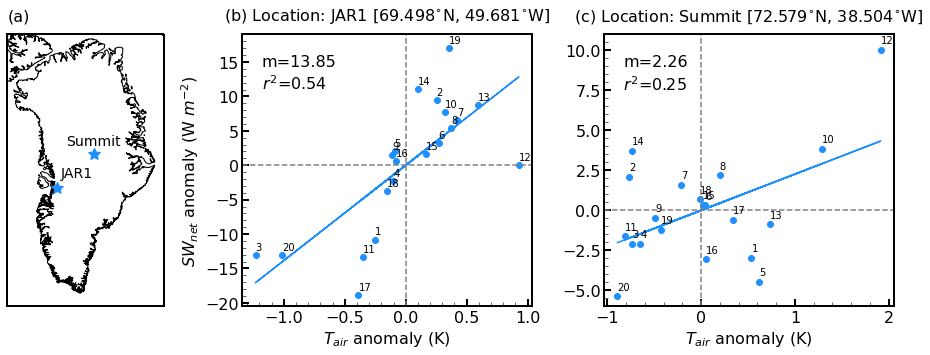

In [48]:
fig = plt.figure(figsize = (16,5))
gs=GridSpec(5,15)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 16

# Location on map
ax0 = plt.subplot(gs[0:5, 0:3], projection=polar_stereographic)
ax0.set_extent([-56.4, -29.6, 58, 84])  # Map bounds, [west, east, south, north]
ax0.coastlines(resolution='10m', zorder=7)

ax0.scatter(lon_JAR1, lat_JAR1, transform=ccrs.PlateCarree(), zorder=15, c='dodgerblue', s=150, marker=(5, 1))
ax0.text(lon_JAR1+1, lat_JAR1+1, 'JAR1', transform=ccrs.PlateCarree(), color='k', fontsize=14)
ax0.scatter(lon_Summit, lat_Summit, transform=ccrs.PlateCarree(), zorder=15, c='dodgerblue', s=150, marker=(5, 1))
ax0.text(lon_Summit-9, lat_Summit+1, 'Summit', transform=ccrs.PlateCarree(), color='k', fontsize=14)
plt.title('(a)', fontsize=size_text, loc='left')

# Ablation zone
ax1 = plt.subplot(gs[0:5,4:9])

plt.scatter(ARCTIC_TREFHT_JJA_stab_JAR1_anom, ARCTIC_FSA_JJA_stab_JAR1_anom, color='dodgerblue')
plt.plot(ARCTIC_TREFHT_JJA_stab_JAR1_anom, ARCTIC_TREFHT_JJA_stab_JAR1_anom*slope1+intercept1, color='dodgerblue')
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.title('(b) Location: JAR1 [69.498$^{\circ}$N, 49.681$^{\circ}$W]', fontsize=size_text)
plt.text(-1.18, 14.4, 'm='+str(round(slope1,2)), fontsize=size_text)
plt.text(-1.18, 11., '$r^2$='+str(round(r_value1**2,2)), fontsize=size_text)

for i, txt in enumerate(time1):
    ax1.annotate(txt, (ARCTIC_TREFHT_JJA_stab_JAR1_anom[i], ARCTIC_FSA_JJA_stab_JAR1_anom[i]+0.7))

ax1.set_ylim([-20.5, 19])
ax1.set_xlabel("$T_{air}$ anomaly (K)", fontsize=size_label)
ax1.set_ylabel("$SW_{net}$ anomaly (W $m^{-2}$)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)

# Accumulation zone
ax2 = plt.subplot(gs[0:5,10:16])

plt.scatter(ARCTIC_TREFHT_JJA_stab_Summit_anom, ARCTIC_FSA_JJA_stab_Summit_anom, color='dodgerblue')
plt.plot(ARCTIC_TREFHT_JJA_stab_Summit_anom, ARCTIC_TREFHT_JJA_stab_Summit_anom*slope2+intercept2, color='dodgerblue')
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.title('(c) Location: Summit [72.579$^{\circ}$N, 38.504$^{\circ}$W]', fontsize=size_text)
plt.text(-0.83, 9., 'm='+str(round(slope2,2)), fontsize=size_text)
plt.text(-0.83, 7.5, '$r^2$='+str(round(r_value2**2,2)), fontsize=size_text)

for i, txt in enumerate(time1):
    ax2.annotate(txt, (ARCTIC_TREFHT_JJA_stab_Summit_anom[i], ARCTIC_FSA_JJA_stab_Summit_anom[i]+0.4))

ax2.set_ylim([-6, 11])
ax2.set_xlabel("$T_{air}$ anomaly (K)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.25)
plt.savefig(
    home_dir + "2022-VR-dynamic-GrIS/github/plot/location_scatter_albedo_feedback_ARCTIC.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

#### For the whole grid

In [49]:
# Calculate the slope of linear regression using detrended SWnet, T2m anomalies
def albedo_feedback(FSA_JJA, TREFHT_JJA): # in dimension [time, lat, lon]

    # Remove the linear trend
    time1=np.arange(1,len(FSA_JJA.time)+1,1)
    # calculate the slope a1 using Barnes Equation (14)
    a1=np.dot(time1-time1.mean(),np.swapaxes(FSA_JJA,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
    a1_broadcast=a1[None,:,:]*time1[:,None,None]
    FSA_JJA_rt=FSA_JJA-a1_broadcast

    a2=np.dot(time1-time1.mean(),np.swapaxes(TREFHT_JJA,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
    a2_broadcast=a2[None,:,:]*time1[:,None,None]
    TREFHT_JJA_rt=TREFHT_JJA-a2_broadcast

    # Calculate anomaly
    FSA_JJA_rt_anom = FSA_JJA_rt - FSA_JJA_rt.mean(dim='time')
    TREFHT_JJA_rt_anom = TREFHT_JJA_rt - TREFHT_JJA_rt.mean(dim='time')

    # Slice the Greenland region
    FSA_JJA_rt_anom_sel = FSA_JJA_rt_anom.sel(lat=slice(56,88)).sel(lon=slice(-80+360,-5+360))
    TREFHT_JJA_rt_anom_sel = TREFHT_JJA_rt_anom.sel(lat=slice(56,88)).sel(lon=slice(-80+360,-5+360))

    # Linear regression
    slope = FSA_JJA_rt_anom_sel[0,:,:] * 0
    intercept = FSA_JJA_rt_anom_sel[0,:,:] * 0
    r_value = FSA_JJA_rt_anom_sel[0,:,:] * 0
    p_value = FSA_JJA_rt_anom_sel[0,:,:] * 0
    std_err = FSA_JJA_rt_anom_sel[0,:,:] * 0

    for i in range(len(slope.lat)):
        for j in range(len(slope.lon)):
            slope[i,j], intercept[i,j], r_value[i,j], p_value[i,j], std_err[i,j] = stats.linregress(TREFHT_JJA_rt_anom_sel[:,i,j], FSA_JJA_rt_anom_sel[:,i,j])

    return slope

In [50]:
# Calculate the slope of linear regression using detrended SWnet, T2m anomalies
def albedo_feedback_vr(FSA_JJA, TREFHT_JJA): # in dimension [time, ncol]

    # Extend another axis
    FSA_JJA_ex2 = np.expand_dims(FSA_JJA, axis=2)
    TREFHT_JJA_ex2 = np.expand_dims(TREFHT_JJA, axis=2)

    # Remove the linear trend
    time1=np.arange(1,len(FSA_JJA.time)+1,1)
    # calculate the slope a1 using Barnes Equation (14)
    a1=np.dot(time1-time1.mean(),np.swapaxes(FSA_JJA_ex2,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
    a1_broadcast=a1[None,:,:]*time1[:,None,None]
    FSA_JJA_rt=FSA_JJA_ex2-a1_broadcast

    a2=np.dot(time1-time1.mean(),np.swapaxes(TREFHT_JJA_ex2,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
    a2_broadcast=a2[None,:,:]*time1[:,None,None]
    TREFHT_JJA_rt=TREFHT_JJA_ex2-a2_broadcast

    # Calculate anomaly
    FSA_JJA_rt_anom = (FSA_JJA_rt - np.mean(FSA_JJA_rt, axis=0)).squeeze()
    TREFHT_JJA_rt_anom = (TREFHT_JJA_rt - np.mean(TREFHT_JJA_rt, axis=0)).squeeze()

    # Mask out regions except for the Greenland region
    FSA_JJA_rt_anom_sel = FSA_JJA * 0 + FSA_JJA_rt_anom
    TREFHT_JJA_rt_anom_sel = TREFHT_JJA * 0 + TREFHT_JJA_rt_anom

    #FSA_JJA_rt_anom_sel = FSA_JJA_rt_anom_sel.where((ARCTIC_lat>=56)&(ARCTIC_lat<=88)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=355))
    #TREFHT_JJA_rt_anom_sel = TREFHT_JJA_rt_anom_sel.where((ARCTIC_lat>=56)&(ARCTIC_lat<=88)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=355))

    # Linear regression
    slope = FSA_JJA_rt_anom_sel[0,:] * 0
    intercept = FSA_JJA_rt_anom_sel[0,:] * 0
    r_value = FSA_JJA_rt_anom_sel[0,:] * 0
    p_value = FSA_JJA_rt_anom_sel[0,:] * 0
    std_err = FSA_JJA_rt_anom_sel[0,:] * 0

    for i in range(len(slope.lndgrid)):
        slope[i], intercept[i], r_value[i], p_value[i], std_err[i] = stats.linregress(TREFHT_JJA_rt_anom_sel[:,i], FSA_JJA_rt_anom_sel[:,i])

    return slope

In [51]:
# Muntjewerf f09
f09_af_JJA_stab = albedo_feedback(f09_FSA_JJA_stab, f09_TREFHT_JJA_stab)
f09_af_JJA_mid = albedo_feedback(f09_FSA_JJA_mid, f09_TREFHT_JJA_mid)
f09_af_JJA_end = albedo_feedback(f09_FSA_JJA_end, f09_TREFHT_JJA_end)

# f09
f09_nohacks_af_JJA_stab = albedo_feedback(f09_nohacks_FSA_JJA_stab, f09_nohacks_TREFHT_JJA_stab)
f09_nohacks_af_JJA_mid = albedo_feedback(f09_nohacks_FSA_JJA_mid, f09_nohacks_TREFHT_JJA_mid)
f09_nohacks_af_JJA_end = albedo_feedback(f09_nohacks_FSA_JJA_end, f09_nohacks_TREFHT_JJA_end)

In [52]:
# ARCTIC
ARCTIC_af_JJA_stab = albedo_feedback_vr(ARCTIC_FSA_JJA_stab, ARCTIC_TREFHT_JJA_stab)
ARCTIC_af_JJA_mid = albedo_feedback_vr(ARCTIC_FSA_JJA_mid, ARCTIC_TREFHT_JJA_mid)
ARCTIC_af_JJA_end = albedo_feedback_vr(ARCTIC_FSA_JJA_end, ARCTIC_TREFHT_JJA_end)

In [53]:
# Values
print('Albedo feedback positive percentage')
print('Year 131-150: ', (ARCTIC_area.where(ARCTIC_af_JJA_stab.values>0).sum()/ARCTIC_area.where(ARCTIC_af_JJA_stab.values>-1000).sum()).values)
print('Year 231-250: ', (ARCTIC_area.where(ARCTIC_af_JJA_mid.values>0).sum()/ARCTIC_area.where(ARCTIC_af_JJA_mid.values>-1000).sum()).values)
print('Year 331-350: ', (ARCTIC_area.where(ARCTIC_af_JJA_end.values>0).sum()/ARCTIC_area.where(ARCTIC_af_JJA_end.values>-1000).sum()).values)

Albedo feedback positive percentage
Year 131-150:  1.0
Year 231-250:  0.9931550966609416
Year 331-350:  0.9747910795181727


In [54]:
# Remap ARCTIC result to f09 grid
ARCTIC2f09_af_JJA_stab = f09_FSA_JJA_stab[0,:,:] * 0
ARCTIC2f09_af_JJA_mid = f09_FSA_JJA_mid[0,:,:] * 0
ARCTIC2f09_af_JJA_end = f09_FSA_JJA_end[0,:,:] * 0
ARCTIC2f09_af_JJA_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_af_JJA_stab, f09_centers, f09_corners)
ARCTIC2f09_af_JJA_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_af_JJA_mid, f09_centers, f09_corners)
ARCTIC2f09_af_JJA_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_af_JJA_end, f09_centers, f09_corners)

### Prepare for plotting SE grids

In [55]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.

    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])


                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)

    return var, verts

In [56]:
# (1)
ARCTIC_af_JJA_stab_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_af_JJA_stab))[0]
ARCTIC_af_JJA_stab_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_af_JJA_stab))[1]

# (2)
ARCTIC_af_JJA_mid_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_af_JJA_mid))[0]
ARCTIC_af_JJA_mid_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_af_JJA_mid))[1]

# (3)
ARCTIC_af_JJA_end_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_af_JJA_end))[0]
ARCTIC_af_JJA_end_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_af_JJA_end))[1]

In [57]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

### Plot

In [50]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

#### (1) Albedo feedback for F09M, F09, and ARCTIC during the stab, mid and end periods

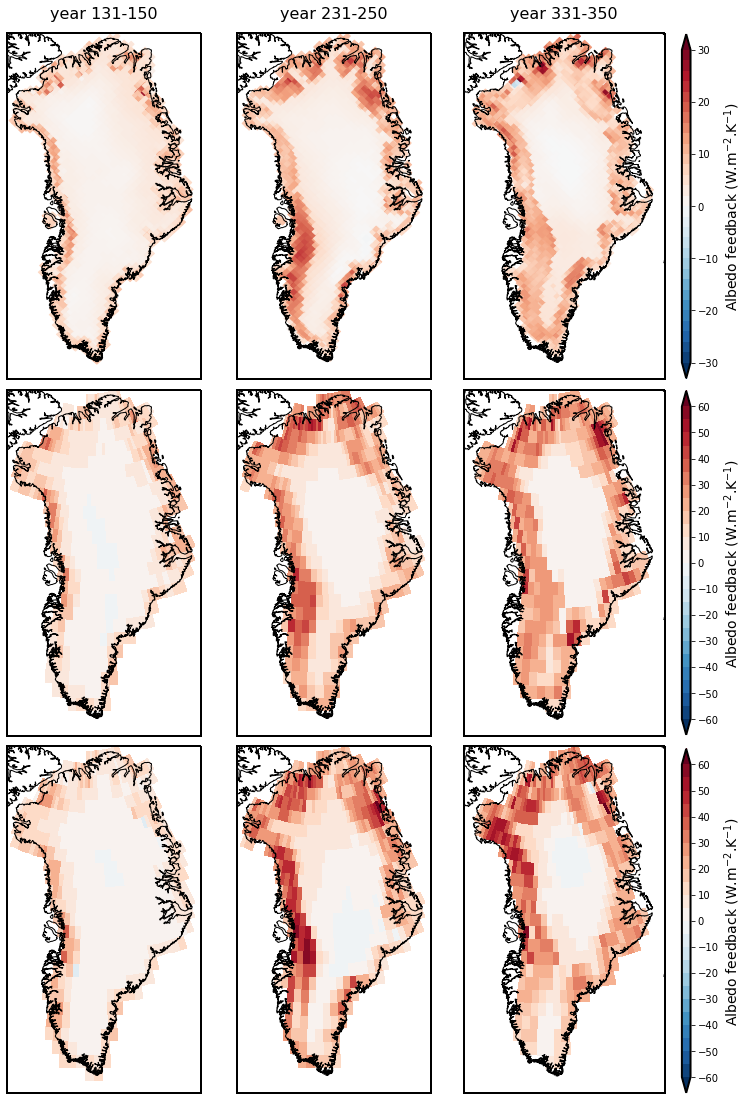

In [60]:
fig = plt.figure(figsize = (12,19.5))
gs=GridSpec(3,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-60.,60.1,5.)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-60.,60.1,10.)

f09_lon_sel = f09_af_JJA_stab.lon
f09_lat_sel = f09_af_JJA_stab.lat

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = PolyCollection(ARCTIC_af_JJA_stab_verts, cmap=cmap2, transform=crs_ll,
                     **kwd_polycollection)
im1.set_array(ARCTIC_af_JJA_stab_var)
im1.set_clim(vmin=-60, vmax=60)
ax1.add_collection(im1)
plt.title('year 131-150', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_af_JJA_mid_verts, cmap=cmap2, transform=crs_ll,
                     **kwd_polycollection)
im2.set_array(ARCTIC_af_JJA_mid_var)
im2.set_clim(vmin=-60, vmax=60)
ax2.add_collection(im2)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_af_JJA_end_verts, cmap=cmap2, transform=crs_ll,
                     **kwd_polycollection)
im3.set_array(ARCTIC_af_JJA_end_var)
im3.set_clim(vmin=-60, vmax=60)
ax3.add_collection(im3)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.634, 0.01, 0.245])
cb = fig.colorbar(im4, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='Albedo feedback (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84])
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon_sel, f09_lat_sel, f09_af_JJA_stab, cmap=cmap2, norm=norm2, transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax5 = plt.subplot(gs[4], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84])
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon_sel, f09_lat_sel, f09_af_JJA_mid, cmap=cmap2, norm=norm2, transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax6 = plt.subplot(gs[5], projection=polar_stereographic)
ax6.set_extent([-56.5, -29.5, 58, 84])
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.pcolormesh(f09_lon_sel, f09_lat_sel, f09_af_JJA_end, cmap=cmap2, norm=norm2, transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.38, 0.01, 0.245])
cb = fig.colorbar(im4, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='Albedo feedback (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax7 = plt.subplot(gs[6], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84])
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon_sel, f09_lat_sel, f09_nohacks_af_JJA_stab, cmap=cmap2, norm=norm2, transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax8 = plt.subplot(gs[7], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84])
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.pcolormesh(f09_lon_sel, f09_lat_sel, f09_nohacks_af_JJA_mid, cmap=cmap2, norm=norm2, transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[8], projection=polar_stereographic)
ax9.set_extent([-56.5, -29.5, 58, 84])
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.pcolormesh(f09_lon_sel, f09_lat_sel, f09_nohacks_af_JJA_end, cmap=cmap2, norm=norm2, transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.245])
cb = fig.colorbar(im7, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='Albedo feedback (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_af_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

#### (2) Albedo feedback for ARCTIC during the stab, mid and end periods, and differences compared with F09M and F09

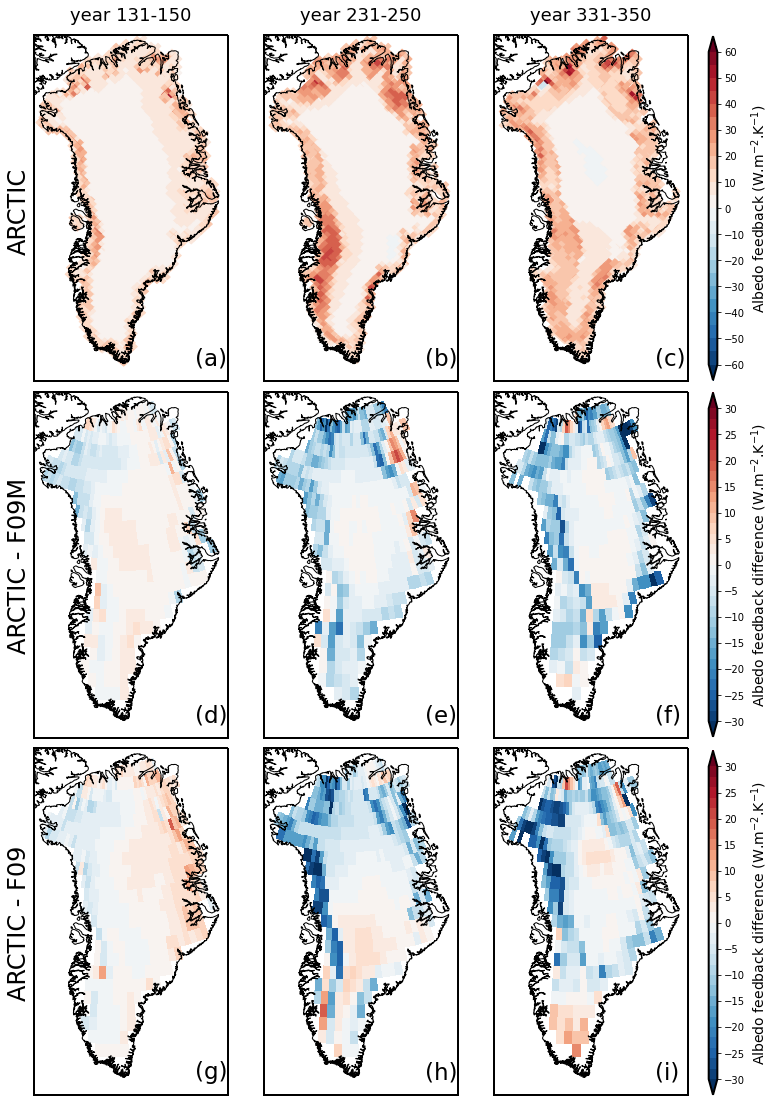

In [59]:
fig = plt.figure(figsize = (12,19.5))
gs=GridSpec(3,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-60.,60.1,5.)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-60.,60.1,10.)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-30.,30.1,2.)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-30.,30.1,5.)

f09_lon_sel = f09_af_JJA_stab.lon
f09_lat_sel = f09_af_JJA_stab.lat

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = PolyCollection(ARCTIC_af_JJA_stab_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im1.set_array(ARCTIC_af_JJA_stab_var)
im1.set_clim(vmin=-60, vmax=60)
ax1.add_collection(im1)
plt.title('year 131-150', fontsize = 18)
ax1.text(-900000, -2400000, 'ARCTIC', rotation=90, fontsize=24)
ax1.text(650000, -3360000, '(a)', fontsize=23)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_af_JJA_mid_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)#
im2.set_array(ARCTIC_af_JJA_mid_var)
im2.set_clim(vmin=-60, vmax=60)
ax2.add_collection(im2)
plt.title('year 231-250', fontsize = 18)
ax2.text(650000, -3360000, '(b)', fontsize=23)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_af_JJA_end_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im3.set_array(ARCTIC_af_JJA_end_var)
im3.set_clim(vmin=-60, vmax=60)
ax3.add_collection(im3)
plt.title('year 331-350', fontsize = 18)
ax3.text(650000, -3360000, '(c)', fontsize=23)

# colorbar
cbar_ax3 = fig.add_axes([0.915, 0.634, 0.01, 0.245])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb3.set_label(label='Albedo feedback (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb3.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84])
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon_sel, f09_lat_sel, -f09_af_JJA_stab+ARCTIC2f09_af_JJA_stab, cmap=cmap2, norm=norm2, transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-900000, -2750000, 'ARCTIC - F09M', rotation=90, fontsize=24)
ax4.text(650000, -3360000, '(d)', fontsize=23)

ax5 = plt.subplot(gs[4], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84])
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon_sel, f09_lat_sel, -f09_af_JJA_mid+ARCTIC2f09_af_JJA_mid, cmap=cmap2, norm=norm2, transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(650000, -3360000, '(e)', fontsize=23)

ax6 = plt.subplot(gs[5], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84])
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.pcolormesh(f09_lon_sel, f09_lat_sel, -f09_af_JJA_end+ARCTIC2f09_af_JJA_end, cmap=cmap2, norm=norm2, transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(650000, -3360000, '(f)', fontsize=23)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.38, 0.01, 0.245])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb6.set_label(label='Albedo feedback difference (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax7 = plt.subplot(gs[6], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84])
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon_sel, f09_lat_sel, -f09_nohacks_af_JJA_stab+ARCTIC2f09_af_JJA_stab, cmap=cmap2, norm=norm2, transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-900000, -2670000, 'ARCTIC - F09', rotation=90, fontsize=24)
ax7.text(650000, -3360000, '(g)', fontsize=23)

ax8 = plt.subplot(gs[7], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84])
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.pcolormesh(f09_lon_sel, f09_lat_sel, -f09_nohacks_af_JJA_mid+ARCTIC2f09_af_JJA_mid, cmap=cmap2, norm=norm2, transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(650000, -3360000, '(h)', fontsize=23)

ax9 = plt.subplot(gs[8], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84])
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.pcolormesh(f09_lon_sel, f09_lat_sel, -f09_nohacks_af_JJA_end+ARCTIC2f09_af_JJA_end, cmap=cmap2, norm=norm2, transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9.text(650000, -3360000, '(i)', fontsize=23)

# colorbar
cbar_ax9 = fig.add_axes([0.915, 0.125, 0.01, 0.245])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb9.set_label(label='Albedo feedback difference (W.$\mathregular{m^{-2}}$.$\mathregular{K^{-1}}$)', size=14)
cb9.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_af_af_diff_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)